In [4]:
from IPython.display import display, HTML

display(
    HTML(
        """
<style>
* {font-family:D2Coding;}
div.container{width:87% !important;}
div.cell.code_cell.rendered{width:100%;}
div.CodeMirror {font-size:12pt;}
div.output {font-size:12pt; font-weight:bold;}
div.input { font-size:12pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:12pt;padding:3px;}
table.dataframe{font-size:12px;}
</style>
"""
    )
)

# <span style='color:red'>06\_스마트번역기(RNN기반의Seq2Seq)</span>

# 인코더 LSTM과 디코더 LSTM (Sequence To Sequence)

- Google Neural Machine Treanlation (GMMT)
- RNN 기반의 Seq2Seq 방식
- 자연어 생성 알고리즘


## 1. 패키지 import & 하이퍼파라미터

- 하이퍼파라미터 : 모델의 정확도 및 학습도에 영향을 미치는 변수


In [5]:
import numpy as np
import pandas as pd
from time import time

from keras.layers import Input, LSTM, Dense
from keras.models import Model
from keras.utils import to_categorical
# 권장 방식
# from tensorflow.keras.layers import Input, LSTM, Dense
# from tensorflow.keras.models import Model
# from tensorflow.keras.utils import to_categorical
# import tensorflow as tf

import matplotlib.pyplot as plt

# 하이퍼파라미터
MY_HIDDEN = 128
MY_EPOCH = 500

## 2. 번역 데이터 불러오기


In [6]:
raw = pd.read_csv("data/translate.csv", header=None)
eng_kor = raw.values.tolist()  # 데이터프레임을 list로 변환
print("영어-한국 번역 데이터 :", eng_kor[:3])
print("영어-한국 번역 데이터 수:", len(eng_kor))

영어-한국 번역 데이터 : [['cold', '감기'], ['come', '오다'], ['cook', '요리']]
영어-한국 번역 데이터 수: 110


## 3. 영어알파벳과 한글문자 리스트 만들기


In [7]:
# 영어 알파벳 리스트
e_alpha = [c for c in "SEPabcdefghijklmnopqrstuvwxyz"]
# print(e_alpha)
# { c:i for i, c in enumerate(e_alpha)}

# 한글 문자 리스트
korean = "".join([data[1] for data in eng_kor])
# set : 중복된 단어 제거 후 리스트형으로 변환
k_ch = list(set([ch for ch in korean]))
# 한글 소팅
k_ch.sort()
# print(k_ch)

k_alpha = pd.read_csv("./data/korean.csv", header=None)[0].to_list()

print(k_alpha, k_ch, k_alpha == k_ch)  #  k_alpha==k_ch 순서와 내용이 모두 같음

# 순서는 무시하고, 내용(요소들)만 같은지
from collections import Counter

list1 = ["가", "간", "나"]
list2 = ["간", "가", "나"]
print(list1 == list2)  # 순서도 같아야 True
print(Counter(list1) == Counter(list2))  # 순서 무시, 내용(요소) 같으면 True

['가', '각', '간', '감', '개', '거', '것', '게', '계', '고', '관', '광', '구', '굴', '규', '그', '금', '기', '깊', '나', '날', '남', '내', '넓', '녀', '노', '놀', '농', '높', '뉴', '늦', '다', '단', '도', '동', '들', '람', '랑', '래', '램', '류', '름', '릎', '리', '많', '망', '매', '머', '먼', '멍', '메', '명', '모', '목', '무', '물', '미', '바', '반', '방', '번', '복', '부', '분', '붕', '비', '뿌', '사', '상', '색', '생', '서', '선', '소', '손', '수', '쉽', '스', '시', '식', '실', '싸', '아', '약', '얇', '어', '언', '얼', '여', '연', '오', '옥', '왼', '요', '용', '우', '운', '움', '위', '유', '은', '을', '음', '의', '이', '익', '인', '읽', '입', '자', '작', '장', '적', '제', '좋', '주', '지', '짜', '쪽', '찾', '책', '출', '칙', '크', '키', '탈', '택', '통', '파', '팔', '편', '피', '핑', '한', '합', '해', '행', '험', '회', '획', '휴', '흐'] ['가', '각', '간', '감', '개', '거', '것', '게', '계', '고', '관', '광', '구', '굴', '규', '그', '금', '기', '깊', '나', '날', '남', '내', '넓', '녀', '노', '놀', '농', '높', '뉴', '늦', '다', '단', '도', '동', '들', '람', '랑', '래', '램', '류', '름', '릎', '리', '많', '망', '매', '머', '먼', '멍', '메', '명', '모', '목', '무', '물', '미', '바'

In [8]:
alpha = e_alpha + k_alpha
print("영어와 한글 알파벳 :", alpha)
alpha_total_size = len(alpha)
print("전체 알파벳 갯수 (원핫인코딩할 size) :", alpha_total_size)
print("한글 알파벳 개수", len(k_alpha))

영어와 한글 알파벳 : ['S', 'E', 'P', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '가', '각', '간', '감', '개', '거', '것', '게', '계', '고', '관', '광', '구', '굴', '규', '그', '금', '기', '깊', '나', '날', '남', '내', '넓', '녀', '노', '놀', '농', '높', '뉴', '늦', '다', '단', '도', '동', '들', '람', '랑', '래', '램', '류', '름', '릎', '리', '많', '망', '매', '머', '먼', '멍', '메', '명', '모', '목', '무', '물', '미', '바', '반', '방', '번', '복', '부', '분', '붕', '비', '뿌', '사', '상', '색', '생', '서', '선', '소', '손', '수', '쉽', '스', '시', '식', '실', '싸', '아', '약', '얇', '어', '언', '얼', '여', '연', '오', '옥', '왼', '요', '용', '우', '운', '움', '위', '유', '은', '을', '음', '의', '이', '익', '인', '읽', '입', '자', '작', '장', '적', '제', '좋', '주', '지', '짜', '쪽', '찾', '책', '출', '칙', '크', '키', '탈', '택', '통', '파', '팔', '편', '피', '핑', '한', '합', '해', '행', '험', '회', '획', '휴', '흐']
전체 알파벳 갯수 (원핫인코딩할 size) : 171
한글 알파벳 개수 142


## 4. 문자당 num 를 갖는 dict 만들기


In [9]:
char_to_num = {}
for i, c in enumerate(alpha):
    # print(c, i)
    char_to_num[c] = i

In [10]:
char_to_num = {c: i for i, c in enumerate(alpha)}
char_to_num

{'S': 0,
 'E': 1,
 'P': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28,
 '가': 29,
 '각': 30,
 '간': 31,
 '감': 32,
 '개': 33,
 '거': 34,
 '것': 35,
 '게': 36,
 '계': 37,
 '고': 38,
 '관': 39,
 '광': 40,
 '구': 41,
 '굴': 42,
 '규': 43,
 '그': 44,
 '금': 45,
 '기': 46,
 '깊': 47,
 '나': 48,
 '날': 49,
 '남': 50,
 '내': 51,
 '넓': 52,
 '녀': 53,
 '노': 54,
 '놀': 55,
 '농': 56,
 '높': 57,
 '뉴': 58,
 '늦': 59,
 '다': 60,
 '단': 61,
 '도': 62,
 '동': 63,
 '들': 64,
 '람': 65,
 '랑': 66,
 '래': 67,
 '램': 68,
 '류': 69,
 '름': 70,
 '릎': 71,
 '리': 72,
 '많': 73,
 '망': 74,
 '매': 75,
 '머': 76,
 '먼': 77,
 '멍': 78,
 '메': 79,
 '명': 80,
 '모': 81,
 '목': 82,
 '무': 83,
 '물': 84,
 '미': 85,
 '바': 86,
 '반': 87,
 '방': 88,
 '번': 89,
 '복': 90,
 '부': 91,
 '분': 92,
 '붕': 93,
 '비': 94,
 '뿌': 95,
 '사': 96,
 '상': 97,
 '색': 98,
 '생': 99,
 '서': 100,

In [11]:
data = eng_kor[0]
print(data)
print(char_to_num["c"], char_to_num["o"], char_to_num["l"], char_to_num["d"])
print(data[0], data[1])
print("인코더 입력 (원핫인코딩 전) :", [char_to_num[c] for c in data[0]])
print("디코더 입력 (원핫인코딩 전) :", [char_to_num[c] for c in "S" + data[1]])  # S 가 0
print("디코더 출력 (원핫인코딩 X) :", [char_to_num[c] for c in data[1] + "E"])

['cold', '감기']
5 17 14 6
cold 감기
인코더 입력 (원핫인코딩 전) : [5, 17, 14, 6]
디코더 입력 (원핫인코딩 전) : [0, 32, 46]
디코더 출력 (원핫인코딩 X) : [32, 46, 1]


In [12]:
# 회소행렬의 원핫인코딩방법1 (희소행렬에서는 pd.get_dummies([2, 9, 7]) 안 씀)
to_categorical([5, 7, 6, 8], num_classes=10)  # 10 이 alpha_total_size 로 넣을 예정

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [13]:
# 회소행렬의 원핫인코딩방법2 (단위행렬을 히용한 원핫인코딩)
np.eye(10)[[5, 7, 6, 8]]  # 10 이 alpha_total_size 로 넣을 예정

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

## 5. 인코더 입력, 디코더 입력, 디코더 출력

- 인코더 입력데이터 : 영어알파벳 → 숫자 → 원핫인코딩 (110, 4, 171)
- 디코더 입력데이터 : 'S' + 한글문자 → 숫자 → 원핫인코딩 (110, 3, 171)
- 디코더 출력데이터 : 한글문자 + 'E' → 숫자 → 원화인코딩(X) 숫자 shape이 (110, 3) 인 list () → 나중에는 110, 3, 1 배열로 변환


In [14]:
def encoding(eng_kor=eng_kor):
    enc_in = []  # 인코더 입력
    dec_in = []  # 디코더 입력
    dec_out = []  # 디코더 출력(타겟)

    for data in eng_kor:
        # 인코더 입력데이터 (영어알파벳 → 숫자 → 원핫인코딩)
        # print(data[0])
        eng = [char_to_num[c] for c in data[0]]
        eng_one = np.eye(alpha_total_size)[eng]
        # print('영어', eng, eng_one)
        enc_in.append(eng_one)  # eng_one의 shape : (4, 171)

        # 디코더 입력데이터 ("S + 한글데이터" → 숫자 → 원핫인코딩)
        kor = [char_to_num[c] for c in "S" + data[1]]
        # to_categorical 사용
        # kor_one = to_categorical(kor, num_classes=alpha_total_size)
        kor_one = np.eye(alpha_total_size)[kor]
        # print('한글 :', kor, kor_one)
        # # kor_one의 shape : (3, 171)
        dec_in.append(kor_one)

        # 디코더 출력데이터 ("한글문자 + E" → 숫자 → 원핫인코딩)
        kor = [char_to_num[c] for c in data[1] + "E"]
        # print(kor)
        dec_out.append(kor)

    return enc_in, dec_in, dec_out

In [15]:
sample = [["cold", "감기"], ["wood", "나무"]]
x_enc, x_dec, y_dec = encoding(sample)

X_enc = np.array(x_enc)
X_dec = np.array(x_dec)
Y_dec = np.array(y_dec)

X_enc.shape, X_dec.shape, Y_dec.shape  # Y_dec를 (2,3,1)

((2, 4, 171), (2, 3, 171), (2, 3))

In [16]:
# 축 증가 방법 1
Y_dec.reshape(2, 3, 1)

array([[[32],
        [46],
        [ 1]],

       [[48],
        [83],
        [ 1]]])

In [17]:
# 축 증가 방법 2 : 증가하는 함수 (맨 마지막 축)
np.expand_dims(Y_dec, axis=-1)

array([[[32],
        [46],
        [ 1]],

       [[48],
        [83],
        [ 1]]])

In [18]:
# 축 증가 방법 3
Y_dec[..., np.newaxis]

array([[[32],
        [46],
        [ 1]],

       [[48],
        [83],
        [ 1]]])

In [19]:
# 축 증가 방법 4
Y_dec[:, :, None]

array([[[32],
        [46],
        [ 1]],

       [[48],
        [83],
        [ 1]]])

## 6. 전체 입력데이터, 타켓데이터 준비


In [20]:
x_enc, x_dec, y_dec = encoding(eng_kor)

X_enc = np.array(x_enc)
X_dec = np.array(x_dec)
# Y_dec = np.array(y_dec).reshape(-1, 3, 1) # 차원 추가
Y_dec = np.expand_dims(y_dec, axis=-1)
# Y_dec = np.array(y_dec)[..., np.newaxis]
# Y_dec = Y_dec[:, :, None]

X_enc.shape, X_dec.shape, Y_dec.shape

((110, 4, 171), (110, 3, 171), (110, 3, 1))

## 7. 모델 구현


In [21]:
# 인코더 LSTM 모델 생성

ENC_IN = Input(shape=(4, alpha_total_size)) # alpha_total_size = 171

_, state_h, state_c= LSTM(units=MY_HIDDEN, # MY_HIDDEN = 128 
                        return_state=True, # return_state=True h 값과 c 받기
                        # return_sequences=False # return_sequences=False 마지막  LSTM 윗 출력 안 받음 (return_sequences=False 마지막 출력값만 받기)
                        )(ENC_IN) 

# 인코더와 디코더 연결 고리
LINK = [state_h, state_c]

# 디코더 LSTM 모델 생성

DEC_IN = Input(shape=(3, alpha_total_size))
DEC_MID = LSTM(units=MY_HIDDEN, 
            # return_state=False
            return_sequences=True,  # 윗 출력 받음   
            )(DEC_IN, initial_state=LINK)

# 디코더 최종 출력층
DEC_OUT = Dense(units=alpha_total_size, 
            activation='softmax')(DEC_MID)


# 모델 생성
model = Model(inputs=[ENC_IN, DEC_IN], 
            outputs=DEC_OUT)

model.summary()


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4, 171)]     0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 3, 171)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        153600      ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
             

## 8. 학습과정 설정 & 학습

In [22]:
model.compile(loss='sparse_categorical_crossentropy', 
            optimizer='rmsprop', 
            metrics=['accuracy'] # metrics 안쓰면 : loss 만 로그 출력
            )

begin = time()

hist = model.fit([X_enc, X_dec], Y_dec, 
          epochs=MY_EPOCH, 
          verbose=1)

end = time()

print('학습시간', end - begin)

Epoch 1/500


2025-06-23 15:12:08.759604: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 2s 56ms/step - loss: 5.1133 - accuracy: 0.2182
Epoch 2/500
4/4 [==============================] - 0s 16ms/step - loss: 4.9259 - accuracy: 0.3333
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 3.9700 - accuracy: 0.3333
Epoch 4/500
4/4 [==============================] - 0s 17ms/step - loss: 3.4734 - accuracy: 0.3333
Epoch 5/500
4/4 [==============================] - 0s 16ms/step - loss: 3.4179 - accuracy: 0.3333
Epoch 6/500
4/4 [==============================] - 0s 16ms/step - loss: 3.3786 - accuracy: 0.3333
Epoch 7/500
4/4 [==============================] - 0s 16ms/step - loss: 3.3525 - accuracy: 0.3333
Epoch 8/500
4/4 [==============================] - 0s 16ms/step - loss: 3.3280 - accuracy: 0.3333
Epoch 9/500
4/4 [==============================] - 0s 16ms/step - loss: 3.3131 - accuracy: 0.3333
Epoch 10/500
4/4 [==============================] - 0s 16ms/step - loss: 3.2796 - accuracy: 0.3333
Epoch 11/500
4/4 [=============

In [23]:
hist.history.keys()

dict_keys(['loss', 'accuracy'])

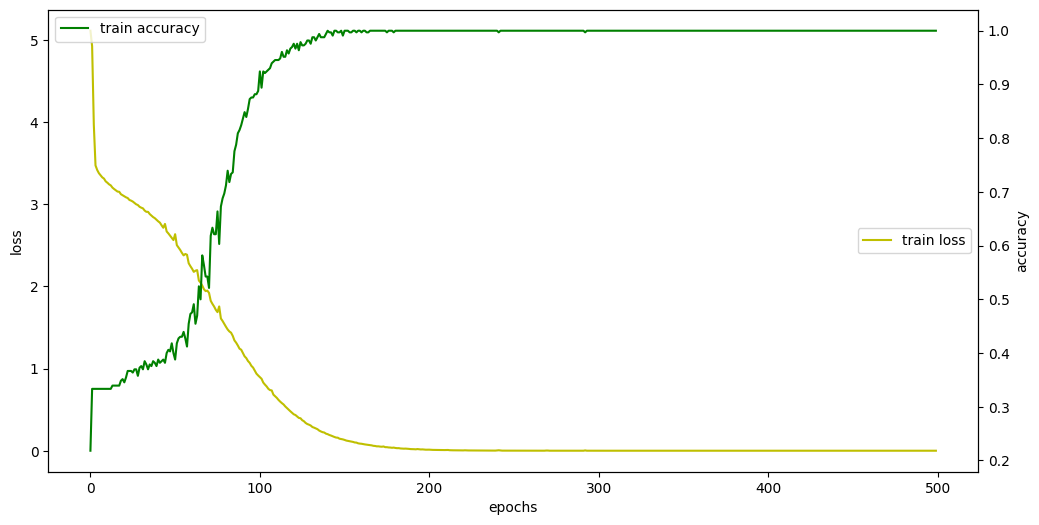

In [24]:
# 5. 모델 학습과정 시각화
fig, loss_ax = plt.subplots(figsize=(12,6))
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
# loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'g', label='train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'b', label='val accuracy')

loss_ax.set_xlabel('epochs')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(loc='upper left')
plt.show()

In [25]:
model.evaluate([X_enc, X_dec], Y_dec)

4/4 [==============================] - 1s 22ms/step - loss: 6.7263e-07 - accuracy: 1.0000


[6.726289711878053e-07, 1.0]

## 9. 모델사용

In [26]:
# 쉬운문제
easy_test=[['cold', 'PP'],
           ['fact', 'PP'],
           ['love', 'PP'],
           ['luck', 'PP'],
           ['milk', 'PP']]
enc_in, dec_in, _ = encoding(easy_test)
enc_in = np.array(enc_in)
dec_in = np.array(dec_in)
enc_in.shape, dec_in.shape

((5, 4, 171), (5, 3, 171))

In [27]:
# 위의 문제 예측하기
pred = model.predict([enc_in, dec_in])
pred.argmax(axis=-1)

1/1 [==============================] - 0s 384ms/step


array([[ 32,  46,   1],
       [ 96, 109,   1],
       [ 96,  66,   1],
       [165, 125,   1],
       [124, 128,   1]])

In [28]:
char_to_num['감'], alpha[32]

(32, '감')

In [29]:
# cold → 감기([32, 46])

In [30]:
# pred[0].argmax(axis=1)
for test, yhat in zip(easy_test, pred):
    # print(f'{test[0]} -> {test[1]} : {yhat.argmax(axis=1)}')
    eng = test[0]
    hat = np.argmax(yhat, axis=-1)
    kor = ''.join([alpha[h] for h in hat[:-1]])
    print("{} → {}".format(eng, kor))

cold → 감기
fact → 사실
love → 사랑
luck → 행운
milk → 우유


In [31]:
# 어려운 문제
hard_test=[['lvoe', 'PP'],
           ['loev', 'PP'],
           ['love', 'PP'],
           ['olve', 'PP'],
           ['eovl', 'PP']]

enc_in, dec_in, _ = encoding(hard_test)
enc_in = np.array(enc_in)
dec_in = np.array(dec_in)
enc_in.shape, dec_in.shape

# 위의 문제 예측하기
pred = model.predict([enc_in, dec_in]).argmax(axis=-1)
[''.join([alpha[h] for h in hat[:-1]]) for hat in pred]

1/1 [==============================] - 0s 23ms/step


['사사', '사랑', '사랑', '사랑', '다다']

In [32]:
for test, yhat in zip(hard_test, pred):
    eng = test[0]
    kor = ''.join([alpha[h] for h in yhat[:-1]])
    print("{} -> {} ({})".format(eng, kor, yhat[:-1]))

lvoe -> 사사 ([96 96])
loev -> 사랑 ([96 66])
love -> 사랑 ([96 66])
olve -> 사랑 ([96 66])
eovl -> 다다 ([60 60])
